In [1]:
import re
import sklearn
import numpy as np
import pandas as pd
from wombat.engine import ml_model
from wombat.engine import parse_input_description as parse_title
from wombat.models import Item
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from wombat.models import dbsession, engine, ItemType, ItemAdjective
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,12)


In [18]:
#query = "SELECT brand, item_type, cost, rent_per_week FROM items WHERE brand in ({}) AND rent_per_week < 600".format(top_brands)
#df = pd.read_sql_query(query, engine)
df = ml_model.canonical_df

# split data into train and test group
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

# copy of train before we delete the 'rent_per_week' and 'title' field. We want title 
# we will need these things before we make dummy variables
df_full_training = df[df['is_train']==False]

print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:', len(test))

# get one-hot columns for brands 
dummy_brands = pd.get_dummies(df['brand'])
df = pd.concat([df, dummy_brands], axis = 1)

df = df.drop('brand', axis = 1)

# get one-hot columns for item_types
dummified_items = pd.get_dummies(df['item_type'])
df = pd.concat([df, dummified_items], axis = 1)
df = df.drop('item_type', axis = 1)
df_brands = df

Number of observations in the training data: 4295
Number of observations in the test data: 1467


In [19]:
# get list of adjective features form database
features_adj = [f.name for f in dbsession.query(ItemAdjective).all()]
item_types   = [item.name for item in dbsession.query(ItemType).all()]

tokenized_titles = []
for title in df['title']:
    parse_title.create_one_hot_row_adj(title, features_adj)
    tokenized_titles.append(parse_title.create_one_hot_row_adj(title, features_adj))
df_adj = pd.DataFrame(tokenized_titles, columns = features_adj)

In [26]:
df = pd.concat([df_brands, df_adj], axis = 1)

In [27]:
y = train['rent_per_week']
features = df.columns.drop(['rent_per_week', 'title']) # just column names

In [28]:
train, test = df[df['is_train']==True], df[df['is_train']==False]
clf = RandomForestRegressor()
clf.fit(train[features], train['rent_per_week'])
#joblib.dump(clf, 'rfr_v0.2.pkl')
#call this with: clf = joblib.load('rfr_v0.2.pkl')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Coefficients: 
 [ 0.69904005]
Mean squared error: 236.55
Variance score: 0.65


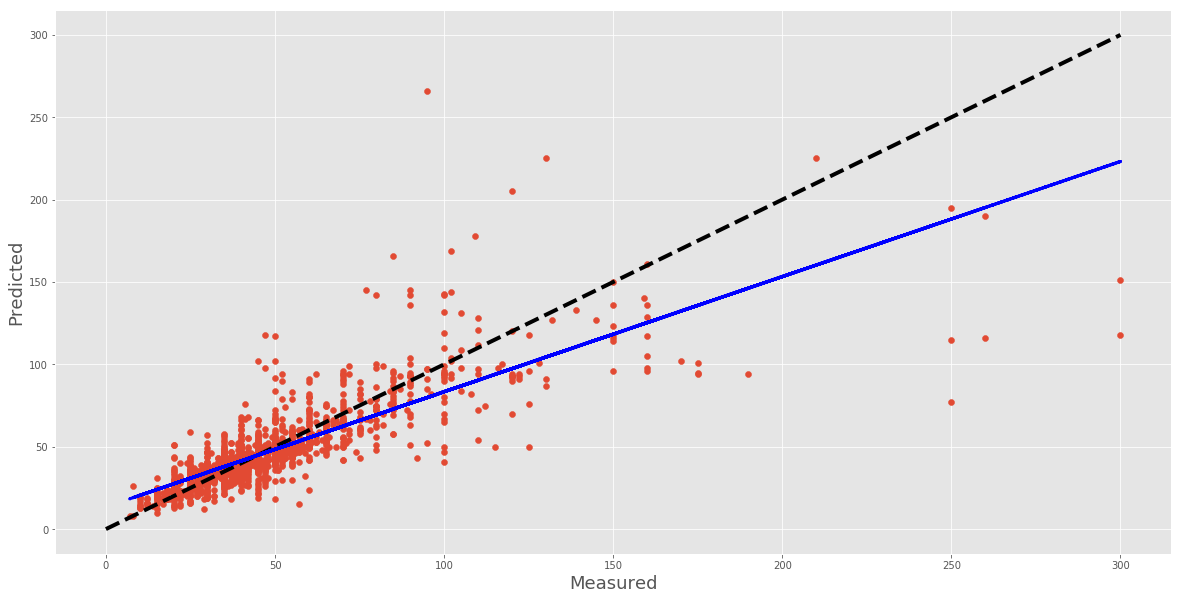

In [76]:
from sklearn import linear_model

rfr_predicted = clf.predict(test[features]).astype(int)

# Create linear regression object for predicted vs measured
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(x = test['rent_per_week'], y = rfr_predicted)
#stopping_value = np.minimum(test['rent_per_week'].max, np.maximum(rfr_predicted))
stopping_value = 300
ax.plot([0, stopping_value], [0, stopping_value], 'k--', lw=4)
ax.set_xlabel('Measured', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
ax.plot(x, reg.predict(x),  'k--', color='blue', linewidth=3)


In [43]:
# make plotly plot
import plotly.plotly as py
import plotly.graph_objs as go

brands = df_full_training['brand'].values
item_types = df_full_training['item_type'].values
titles = df_full_training['title'].values
labels = []
for i in list(range(0, len(brands))):
    labels.append("{}, {}, {}".format(brands[i], item_types[i], titles[i]))

data = [
    go.Scatter(
        x=test['rent_per_week'],
        y=rfr_predicted,
        mode='markers',
        text=labels
    )
]
layout = go.Layout(
    title='Measured vs Predicted outcomes using Random Forest model'
)
fig = go.Figure(data=data, layout=layout)
plot_url = py.plot(fig, filename='meas-v-pred-rfr-2017-06-12')


Coefficients: 
 [ 0.69904005]
Mean squared error: 236.55
Variance score: 0.65


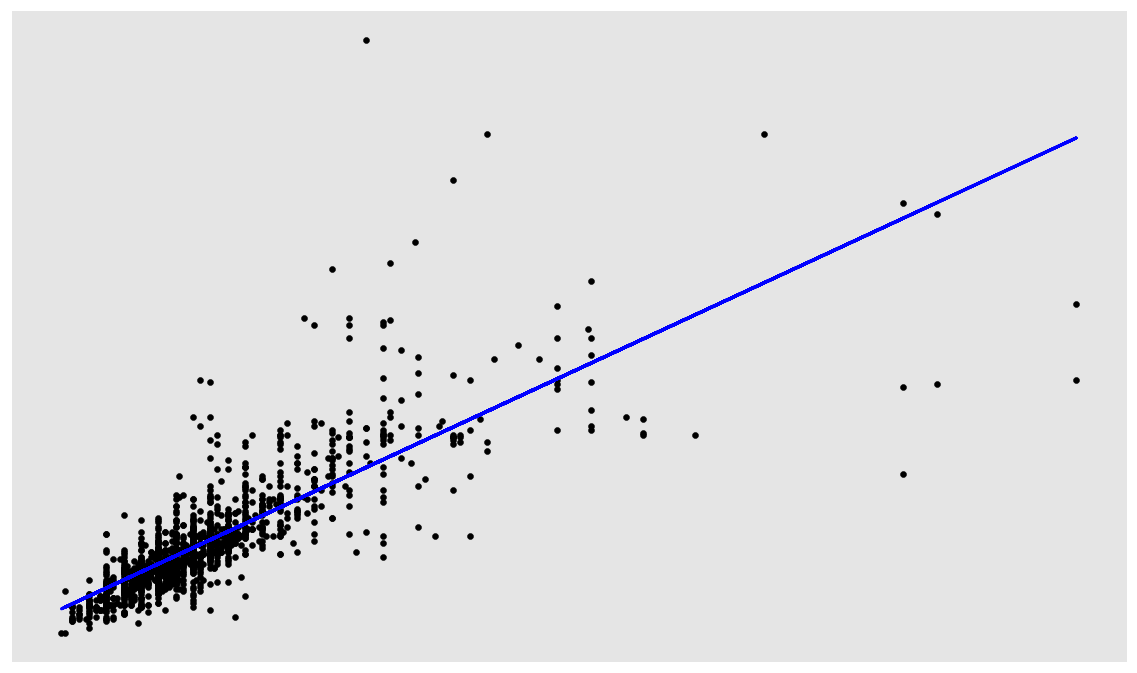

In [69]:
from sklearn import linear_model
# Create linear regression object
reg = linear_model.LinearRegression()

x = test['rent_per_week'].values.reshape(-1,1)
y = np.array(rfr_predicted)

# Train the model using the training sets
reg.fit(x, y)
# The coefficients
print('Coefficients: \n', reg.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((reg.predict(x) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % reg.score(x, y))

# Plot outputs
plt.scatter(x, y,  color='black')
plt.plot(x, reg.predict(x), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()